# not-MIWAE: Deep Generative Modelling with Missing not at Random Data
This notebook illustrates how to fit a *deep latent variable model* to data affected by a missing process which depends on the missing data itself, i.e. *missing not at random*.

We fit a linear PPCA-like model to a relatively small UCI dataset.

### Preamble

In [920]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import time


In [921]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp


In [922]:

# import sys
# sys.path.append('./')



plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['lines.linewidth'] = 2.5


### Load data
Here we use the white-wine dataset from the UCI database

In [924]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1] 

### Settings

In [925]:
N, D = data.shape
n_latent = D
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [926]:
# ---- standardize data (indication sur la moyenne et la dispersion des données?)
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation 
p = np.random.permutation(N)
data = data[p, :]  # Cette fois, c'est un tableau NumPy, donc cette syntaxe est valide

# ---- Utilisation des données pour train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [929]:
 # ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

### Inputs
Let's first define the inputs of the model
- x_pl: data input
- s_pl: mask input
- n_pl: number of importance samples

In [930]:
print("Creating graph...")

tf.compat.v1.disable_eager_execution()

sess = tf.compat.v1.Session()
tf.compat.v1.reset_default_graph()
# ---- input
with tf.compat.v1.variable_scope('input'):
    x_pl = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, D], 'x_pl')
    s_pl = tf.compat.v1.placeholder(tf.compat.v1.float32, [None, D], 's_pl')
    n_pl = tf.compat.v1.placeholder(tf.compat.v1.int32, shape=(), name='n_pl')

Creating graph...


the noise variance is learned as a shared parameter

In [932]:
# ---- parameters
with tf.compat.v1.variable_scope('data_process'):
    logstd = tf.compat.v1.get_variable('logstd', shape=[])

### Encoder
The encoder / inference network consists of two hidden layers with 128 units and tanh activation

In [933]:
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x)

q_mu = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x)

q_logstd = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                           name='q_logstd')(x)

### Variational distribution

In [934]:
q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.compat.v1.exp(q_logstd))

# ---- sample the latent value
l_z = q_z.sample(n_pl)                    # shape [n_samples, batch_size, dl]
l_z = tf.compat.v1.transpose(l_z, perm=[1, 0, 2])   # shape [batch_size, n_samples, dl]

### Decoder

In [935]:
mu = keras.layers.Dense(units=D, activation=None, name='mu')(l_z)
print(mu.shape)

(None, None, 11)


### Observation model / likelihood function

In [936]:
p_x_given_z = tfp.distributions.Normal(loc=mu, scale=tf.exp(logstd))

## New missing model :

### Encoder : 

In [937]:
x_m = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
x_m = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x_m)

q_mu_m = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x_m)

q_logstd_m = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                           name='q_logstd')(x_m)

### Decoder

In [938]:
q_z_m = tfp.distributions.Normal(loc=q_mu_m, scale=tf.compat.v1.exp(q_logstd_m))

# ---- sample the latent value
l_z_m = q_z_m.sample(n_pl)                    # shape [n_samples, batch_size, dl]
print(l_z_m.shape)
l_z_m = tf.compat.v1.transpose(l_z_m, perm=[1, 0, 2])   # shape [batch_size, n_samples, n_latent]

mu_m = keras.layers.Dense(units=D, activation=tf.nn.tanh, name='mu')(l_z_m)


(None, None, 11)


### Combined input

In [939]:
l_out_mixed =  tf.compat.v1.expand_dims(x_pl * s_pl, axis=1) + mu * tf.compat.v1.expand_dims(1 - s_pl, axis=1) 

### Missing Model combining input and latent variable 

We include the missing model as a logistic regression in each feature dimension and output of the previous decoder which is dependind on the latent variable.

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m,z_{mask}}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m,z_{mask}}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) + \gamma \mu_m$$


In [ ]:

W = tf.compat.v1.get_variable('W', shape=[1, 1, D ]) 
#W_soft = -tf.compat.v1.nn.softplus(W) #self-masking known
b = tf.compat.v1.get_variable('b', shape=[1, 1, D ])

gamma = tf.compat.v1.get_variable('gamma', shape=[1, 1, n_latent], initializer=tf.initializers.glorot_uniform())
mu_m_p = tf.compat.v1.expand_dims(tf.compat.v1.reduce_mean(mu_m, axis=1), axis=1)
logits = - W * (l_out_mixed - b) + gamma * mu_m

# Calcul de la distribution Bernoulli pour le masque
p_s_given_x_z_mask = tfp.distributions.Bernoulli(logits=logits)
log_p_s_probs = p_s_given_x_z_mask.log_prob(tf.compat.v1.expand_dims(s_pl, axis=1))


### Evaluating likelihoods

In [942]:
# ---- evaluate the observed data in p(x|z)
log_p_x_given_z = tf.compat.v1.reduce_sum(tf.compat.v1.expand_dims(s_pl, axis=1) * 
                                p_x_given_z.log_prob(tf.compat.v1.expand_dims(x_pl, axis=1)), axis=-1)  # sum over d-dimension

# --- evaluate the z-samples in q(z|x)
q_z2 = tfp.distributions.Normal(loc=tf.compat.v1.expand_dims(q_z.loc, axis=1), scale=tf.compat.v1.expand_dims(q_z.scale, axis=1))
log_q_z_given_x = tf.compat.v1.reduce_sum(q_z2.log_prob(l_z), axis=-1)

## NEW ##
# --- evaluate the z-samples in q(z_mask|x)
q_z2_m = tfp.distributions.Normal(loc=tf.compat.v1.expand_dims(q_z_m.loc, axis=1), scale=tf.compat.v1.expand_dims(q_z_m.scale, axis=1))
log_q_z_mask_given_x = tf.compat.v1.reduce_sum(q_z2_m.log_prob(l_z_m), axis=-1)

# ---- evaluate the z-samples in the prior p(z)
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
log_p_z = tf.compat.v1.reduce_sum(prior.log_prob(l_z), axis=-1)

## NEW ##
# ---- evaluate the z-samples in the prior p(z_mask)
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
log_p_z_mask = tf.compat.v1.reduce_sum(prior.log_prob(l_z_m), axis=-1)

## NEW ##
# ---- evaluate the observed data in p(s|z_mask)
prob = p_s_given_x_z_mask.log_prob(tf.compat.v1.expand_dims(s_pl, axis=1))
log_p_s_given_x_z_mask = tf.compat.v1.reduce_sum(  prob, axis=-1)  # sum over d-dimension

### Losses for the MIWAE and not-MIWAE respectively

In [943]:
lpxz = log_p_x_given_z
lpz = log_p_z
lqzmx = log_q_z_mask_given_x
lqzx = log_q_z_given_x
lpsxzm = log_p_s_given_x_z_mask
lpzm = log_p_z_mask

# ---- MIWAE
# ---- importance weights :
l_w = lpxz + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.compat.v1.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.compat.v1.log(tf.compat.v1.cast(n_pl, tf.compat.v1.float32))

# ---- average over minibatch to get the average llh
MIWAE = tf.compat.v1.reduce_mean(log_avg_weight, axis=-1)


# ---- not-MIWAE
# ---- importance weights :
l_w = lpxz + lpz - lqzx   + lpsxzm + lpzm - lqzmx

# ---- sum over samples
log_sum_w = tf.compat.v1.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.compat.v1.log(tf.compat.v1.cast(n_pl, tf.compat.v1.float32))

# ---- average over minibatch to get the average llh
notMIWAE = tf.compat.v1.reduce_mean(log_avg_weight, axis=-1)


In [944]:
def imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        if i % 100 == 0:
            print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


def not_imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x,_log_p_s_given_x_z_mask,_log_p_z_mask,_log_q_z_mask_given_x  = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x_z_mask,log_p_z_mask,log_q_z_mask_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z  + _log_p_z - _log_q_z_given_x + _log_p_s_given_x_z_mask + _log_p_z_mask - _log_q_z_mask_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        #if i % 100 == 0:
            #print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


### Training stuff

In [945]:
# ---- training stuff
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
global_step = tf.compat.v1.Variable(initial_value=0, trainable=False)
optimizer = tf.compat.v1.train.AdamOptimizer()

### Choose wether you want to train the MIWAE or the notMIWAE

In [946]:
loss = -notMIWAE
# loss = -MIWAE

tvars = tf.compat.v1.trainable_variables()
train_op = optimizer.minimize(loss, global_step=global_step, var_list=tvars)
sess.run(tf.compat.v1.global_variables_initializer())

### Do the training

0/100000 updates, 0.39 s, 21.81 train_loss, 21.93 val_loss,  9.62 accuracy 
Iteration 0, RMSE :  1.2226662739392904
500/100000 updates, 10.89 s, 16.31 train_loss, 15.70 val_loss,  11.10 accuracy 
1000/100000 updates, 1.17 s, 15.14 train_loss, 13.97 val_loss,  12.64 accuracy 
1500/100000 updates, 1.17 s, 12.96 train_loss, 13.05 val_loss,  13.52 accuracy 
2000/100000 updates, 1.16 s, 11.57 train_loss, 12.67 val_loss,  13.88 accuracy 
2500/100000 updates, 1.17 s, 11.68 train_loss, 12.42 val_loss,  14.16 accuracy 
3000/100000 updates, 1.20 s, 11.81 train_loss, 12.32 val_loss,  14.28 accuracy 
3500/100000 updates, 1.22 s, 12.83 train_loss, 12.08 val_loss,  14.36 accuracy 
4000/100000 updates, 1.23 s, 12.13 train_loss, 12.09 val_loss,  14.35 accuracy 
4500/100000 updates, 1.45 s, 10.96 train_loss, 11.99 val_loss,  14.47 accuracy 
5000/100000 updates, 1.19 s, 11.58 train_loss, 11.94 val_loss,  14.49 accuracy 
Iteration 5000, RMSE :  1.3157868219609987
5500/100000 updates, 7.24 s, 11.90 train_

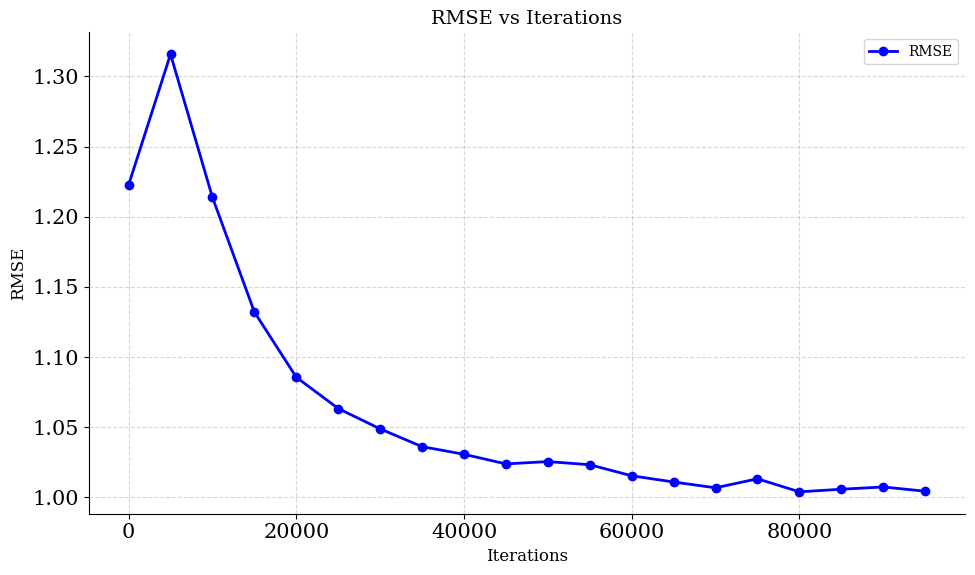

<Figure size 640x480 with 0 Axes>

In [ ]:
batch_pointer = 0

start = time.time()
best = float("inf")
Xval = data.copy()
max_iter = 100000
rmse_list=[]
for i in range(max_iter):
    x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
    s_batch = S[batch_pointer: batch_pointer + batch_size, :]

    _, _loss, _step = sess.run([train_op, loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

    batch_pointer += batch_size
    
    if batch_pointer > N - batch_size:
        batch_pointer = 0

        p = np.random.permutation(N)
        Xz = Xz[p, :]
        S = S[p, :]
    
    if i % 500 == 0:
        took = time.time() - start
        start = time.time()
        
        # --- change the following batch if you want a true validation set
        x_batch = Xz  
        s_batch = S
        
        val_loss, _step = sess.run([loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})


        

        print("{0}/{1} updates, {2:.2f} s, {3:.2f} train_loss, {4:.2f} val_loss".format(i, max_iter, took, _loss, val_loss))
    if i % 5000 == 0:
        rmse, imputations = not_imputationRMSE(sess, Xval, Xnan, 1000)
        print(f"Iteration {i}, RMSE : ",rmse)
        rmse_list.append(rmse)

        

import matplotlib.pyplot as plt

iterations = list(range(0, len(rmse_list) * 5000, 5000))

# Plot de la RMSE
plt.figure(figsize=(10, 6))  
plt.plot(iterations, rmse_list, marker='o', linestyle='-', color='b', linewidth=2, markersize=6, label='RMSE')

plt.title("RMSE vs Iterations", fontsize=14)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig("rmse_vs_iterations_z_mask.png", dpi=300)





### Single imputation RMSE
The *self-normalized importance sampling* approach for the MIWAE is described in this [paper](https://arxiv.org/pdf/1812.02633.pdf). This needs to be modified slightly in the MNAR case to account for the missing model, as described in the not-MIWAE paper

### Calculate the single imputation RMSE using 10k importance samples
If you used the MIWAE loss use the imputationRMSE 

If you used the notMIWAE loss use the not_imputationRMSE

In [948]:
# ---- S has been permuted during training, so just reinstantiate it
S = np.array(~np.isnan(Xnan), dtype=np.float32)

rmse, imputations = not_imputationRMSE(sess, Xtrain, Xnan, 10000)
#rmse, imputations = imputationRMSE(sess, Xtrain, Xnan, 10000)

print("imputation RMSE: ", rmse)

imputation RMSE:  0.9961765665466428


### Compare to missForest and MICE

In [949]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [950]:
estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mf = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

' estimator = RandomForestRegressor(n_estimators=100)\nimp = IterativeImputer(estimator=estimator)\nimp.fit(Xnan)\nXrec = imp.transform(Xnan)\nrmse_mf = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S)) '

In [951]:
print("missForst imputation RMSE: ", rmse_mf)

In [952]:
imp = IterativeImputer(max_iter=100)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
RMSE_iter = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

In [953]:
print("MICE, imputation RMSE", RMSE_iter)

MICE, imputation RMSE 1.4102763723316922


### Inspect the learned missing model
There is a separate missing process in each feature dimesion, inspect each of them, plot as function of feature value.

In [ ]:

Xz = Xnan.copy()
Xz[np.isnan(Xnan)] = 0
S = np.array(~np.isnan(Xnan), dtype=np.float32)
L=1000
_W, _b,_l_z_m_p,_gamma = sess.run([W, b,mu_m_p,gamma],{x_pl: Xval, s_pl:S, n_pl: L})
x = np.linspace(-2, 2, 100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

plt.figure()
i=0
for d in range(D // 2):
    logits = _W[i][i][d] * (x - _b[i][i][d] )+ _gamma[i][i][d] * _l_z_m_p[i][i][d]
    psx = sigmoid(logits)
    plt.plot(x, psx)
    
plt.xlabel('feature value')
plt.ylabel('$p(s|x)$')
plt.show()
plt.close()

This should illustrate that the probability of the feature value being observed when it is below the feature mean should be close to 1, while the probability of being observed above the feature mean should be close to 0.

### Close the session

In [883]:
# sess.close()